#The GSS Dataset

The General Social Survey (GSS) collects social data from the population of the United States. It is funded by the Sociology Program of the National Science Foundation with the aim of providing students and scholars data source on various topics in sociology. On average, it has been conducted every two years since 1972, with 29 surveys up to now. It is the only full-probability, personal-interview survey designed to monitor changes in both social characteristics and attitudes currently being conducted in the United States. Because the questions in the social survey have remained the same for so many years, it is a very useful dataset to investigate social trends with. 
 
Among the topics covered are civil liberties, crime and violence, intergroup tolerance, morality, national spending priorities, psychological well-being, social mobility, and stress and traumatic events. Altogether the GSS is a very extensive source for sociological and attitudinal trend data covering the United States.


In [4]:
# import section

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

#Preprocessing

Importing the full GSS datafile over all years does not work, so we needed to import every year separately. The files of all available years are in one directory on our computers, and LoadData function below loops through every year in the directory and appends it to the total data file. Total_data is a dictionary with all the years as keys and the data set in Dataframe format as values. Initially we worked in Spyder as we could collaborate using Github, but there we had to load the data everytime we ran the full program, which took a lot of time. We made a separate data loading program before we realized that Jupyter works with blocks. Luckily we could incorporate some of our previous code, and we now work on this notebook through Github, although the updated file has to be uploaded to the server each time. 

In [6]:
# Data loading function

def LoadData():
    year = 1972
    total_data = {}
    years = []
    for i in range(28):
        if year == 1979 or year == 1981 or year == 1984 or year == 1986 or year ==1992:
            year += 1
        years.append(str(year))
        print year,
        data = pd.io.stata.read_stata("/Users/jorrenbosga/Desktop/AUC/Masterclass/MasterclassBDProject/GSS" + str(year) + ".DTA")
        total_data[str(year)] = data
        year += 1
        if year > 1994:
            year += 1
        
    print "Data Loaded"
    return total_data

total_data = LoadData()

 1972 1973 1974 1975 1976 1977 1978 1980 1982 1983 1985 1987 1988 1989 1990 1991 1993 1994 1996 1998 2000 2002 2004 2006 2008 2010 2012 2014 Data Loaded


##Preprocessing (continued)

After having loaded the data, we noticed that the answers to the survey questions are not constant over the years. In for instance the category religion, some additional religions are added over the years. In order for us to be able to analyse the data properly, we decided that it was necessary to add all possible answers to each category for every year. The AllAnswers function does this for a specified category. If a question is left open, the entry will be NaN (not a natural number). We decided to remove these from the population, as these entries do not contribute to the data, and cause issues when left in (especially if answers are numbers).

In [3]:
# Returns a list of all possible answers in one category over all years
def AllAnswers(category):
    answers_cat = []
    for year in total_data.keys():
        if category not in total_data[year].keys():
            continue
        else:
            cat = getattr(total_data[year], category)
            for answer in cat:
                if type(answer) == str:
                    answer = answer.lower()
                if answer not in answers_cat:
                    answers_cat.append(answer)
    NaNless = []
    for item in answers_cat:
        if type(item) == str:
            NaNless.append(item)
        else:
            if np.isnan(item) == False:
                NaNless.append(item)
    return NaNless



## Preprocessing (continued) and helper functions
The block below is dedicated to calculating proportions of answers within a certain category in one year. This is useful for getting a general idea of distributions within a single year. The first function, Count, counts the frequencies of the answers to a survey question (category), and returns them in a dictionary. The second function, CategoryCompletion, appends the answers that were not chosen or included in the options for a survey question of a single year to the output of the Counted function with a very small value (such that entropy calculations are not affected). The last function, Proportions, transforms the frequencies into proportions and returns them in a list.

In [25]:
# Counting function
# Returns dictionary with frequency of all answers in a chosen category
def Count(year, category):
    if category not in total_data[year].keys():
        return "Error: category nonexistent"
    else:
        filtered = getattr(total_data[year], category)
        counted = {}
        for answer in filtered:
            if type(answer) == str:
                answer = answer.lower()
            if answer not in counted:
                counted[answer] = 1
            else:
                counted[answer] = counted[answer] + 1   
        return counted

# Returns completed dictionary of answers to some categories with keys answers and values counts. Non-existent answers
# in some year are given count = 1e-16
def CategoryCompletion(year, category):
    frequency = Count(year, category)
    if type(frequency) == str:
        return frequency
    allanswers = AllAnswers(category)
    for answer in allanswers:
        if answer not in frequency.keys():
            frequency[answer] = 1e-16
    return frequency
    
# Proportion function
# Returns list with proportions based on counting function
def Proportions(year, category):  # input should be output of Count function
    frequencies = CategoryCompletion(year, category)
    if type(frequencies) == str:
        return frequencies
    numbervals = frequencies.values()
    population = 0
    proportions = []
    for frequency in numbervals:
        population += frequency
    for frequency in numbervals:
        proportions.append(float(frequency) / float(population))
        
    return proportions

## Helper functions for partial populations and Kullback-Leibler divergence

While the block above focuses on single categories, it is statistically speaking more useful to look at correlations between proportions within categories. The block below performs this action by calculating the Kullback-Leibler divergence between the general opinion on a certain subject and the opinion of a subgroup on a certain subject (for example, what is the divergence between the opinion on premarital sex of protestants and the opinion of the whole population on that topic?). The block is largely similar to the block above, but the functions CrossCount, CrossCategoryComplete, and CrossProportions only take the answers of a subset of the population to a certain question into account (in code: total_data["1990", premarsx][religion == "protestant"]).

In [5]:
# Returns a dictionary of all answers to 'category1' in 'year' within subcategory of category2     
def CrossCount(year, category1, category2, subcategory):
    if category1 not in total_data[year].keys():
        return "Error: category 1 nonexistent"
    elif category2 not in total_data[year].keys():
        return "Error: category 2 & subcategory nonexistent"
    else:
        filtered = getattr(total_data[year], category1)[(getattr(total_data[year], category2)) == subcategory]
        counted = {}
        for answer in filtered:
            if type(answer) == str:
                answer = answer.lower()
            if answer not in counted:
                counted[answer] = 1
            else:
                counted[answer] += 1   
        return counted
    
# returns completed dictionary from crosscount
def CrossCategoryComplete(year, category1, category2, subcategory):
    frequencies = CrossCount(year, category1, category2, subcategory)
    totalcats = AllAnswers(category1)
    if type(frequencies) == str:
        return frequencies
    for category in totalcats:
        if category not in frequencies.keys():
            frequencies[category] = 1e-16
    return frequencies

# Returns list with proportions of answers to category1 within subcategory of category2
def CrossProportions(year, category1, category2, subcategory):
    counted = CrossCategoryComplete(year, category1, category2, subcategory)
    if type(counted) == str:
        return counted
    numbervals = counted.values()
    totalval = 0
    proportions = []
    for item in numbervals:
        totalval += item
    for item in numbervals:
        proportions.append(float(item) / float(totalval))
    return proportions

# Returns the Kullback-Leibler divergence between the answers to category1 of the total population and 
# subcategory of category 2
def Entropy(year, category1, category2, subcategory):
    dist1 = CrossProportions(year, category1, category2, subcategory)
    if type(dist1) == str:
        return dist1
    dist2 = Proportions(year, category1)
    if len(dist1) != len(dist2):
        params = [dist1, dist2]
        lengths = [len(dist1), len(dist2)]
        maxlength = max(lengths)    
        for param in params:
            if len(param) < maxlength:
                for i in range(maxlength - len(param)):
                    param.append(1e-16)
    entropy = sp.stats.entropy(dist1, dist2)
    return entropy

## Helper function divergence calculation
With the means to calculate divergences in place, we want to be able to compute divergences for a whole list of categories between the total population and a partial population. The function below is designed to calculate the divergences between the opinions of the general population and each of the largest religious subgroups (protestant, jewish, catholic, none) on a wide range of topics, specified in ListofCategories.

In [6]:
# Returns a list of tuples of the Kullback-Leibler divergences between the total population and 
# subcategory of category2 for a list of different categories (questions)
def ListofEntropies(ListofCategories, category2, subcategory):
    Entropylist = []
    #Loop over categories
    for category1 in ListofCategories:
        entropies = []
        #Loop over years
        for year in total_data.keys():
            if category1 in total_data[year].keys() and category2 in total_data[year].keys():
                a = Entropy(str(year), category1, category2, subcategory)
                entropies.append(a)
        Entropylist.append((np.mean(entropies), category1))
        Entropylist.sort()
        ListEntropies = []
        for i in reversed(Entropylist):
            ListEntropies.append(i)
    return ListEntropies

## Plot and distribution functions
In contrast the last sections, the block below is dedicated to return distributions of some answers to some question. We want to look at how distributions of particular religions or particular answers to questions have changed over time. We have made two functions to plot the distributions of a set of particular religions over time with all other religions accumulated in 'other'. The other two functions are designed to return the distribution over all years of some answer to a question of the total population or just a certain part of the population

In [7]:
# Returns a list of distributions of the population that has some religion (belief), accumulating all smaller religions
# in others
def Religionsdist(total_data, belief, others, years):
    Distribution = []
    for year in years: 
        believers = 0
        population = 0
        for believer in getattr(total_data[str(year)], 'relig'):
            if type(believer) == str:
                believer = believer.lower()
            if believer == belief:
                believers += 1
            if belief == 'other':
                if believer in others:
                    believers +=1
            if believer != 0:
                population += 1
        Distribution.append(float(believers)/float(population))
    return Distribution

# Makes plots of distributions of the population that has the belief in list 'beliefs'
def Religionplots(total_data, beliefs, others):
    Numberofbeliefs = len(beliefs)
    # Create list of years
    years = []
    for key in total_data.keys():
        years.append(int(key))
    years.sort()
    for i, belief in enumerate(beliefs):
        Distribution = Religionsdist(total_data, belief, others, years)
        plt.figure(1,(8,25))
        plt.subplot(Numberofbeliefs,1,i+1)
        plt.plot(years, Distribution)
        plt.ylabel("Probability")
        plt.xlabel("Year")
        plt.title(belief)
        plt.tight_layout()
        
# Returns a list of distributions of the total population that gives 'answer' to question 'category1'
def distributiontotalpop(total_data, category1, askedanswer):
    Distribution = []
    years = []
    yearlist = []
    for key in total_data.keys():
        years.append(key)
    years.sort()
    for year in years:
        positive = 0
        if category1 in total_data[year]:
            for answer in getattr(total_data[str(year)], category1):
                if type(answer) == str:
                    answer = answer.lower()
                if answer == askedanswer:
                    positive += 1
            Distribution.append(positive/float(len(getattr(total_data[str(year)], category1))))
            yearlist.append(year)
    return Distribution, yearlist

# Returns a list of distributions of a constricted population that gives 'answer' to question 'category1'
def distributionpartialpop(total_data,category1, askedanswer, category2, subcategory):
    Distribution = []
    years = []
    yearlist = []
    for key in total_data.keys():
        years.append(key)
    years.sort()
    for year in years:
        positive = 0
        if category1 in total_data[year][getattr(total_data[year], category2) == subcategory]:    
            for answer in getattr(total_data[str(year)], category1)[getattr(total_data[str(year)], category2) == subcategory]:
                if type(answer) == str:
                    answer = answer.lower()
                if answer == askedanswer:
                    positive += 1
            Distribution.append(positive/float(len(getattr(total_data[str(year)],category1)[getattr(total_data[str(year)], category2) == subcategory])))
            yearlist.append(year)
    return Distribution, yearlist                

# Data characterisation

First, we select a set of questions based on the frequency of their occurence over the years (e.g. questions that were asked in most years), and on their relevance to American society (such as opinions on gun laws, gay rights, political affiliations, etc.). For each of these questions we will compute the Kullback-Leibler divergence to see for each religion what its impact is on each of the categories. The Kullback-Leibler divergence is a useful measure from probability and information theory to demonstrate the difference between probability distributions between two groups. This way, we want to single out in what category, the partial population of a certain religion is very different from the total population. Or, in other words, what category is most probably correlated with some religion.
The output will be a bar graph for each of the categories displaying its divergence between the total population and the partial population belonging to the particular religion. We will have a closer look at the questions that score the highest divergence for each religion.

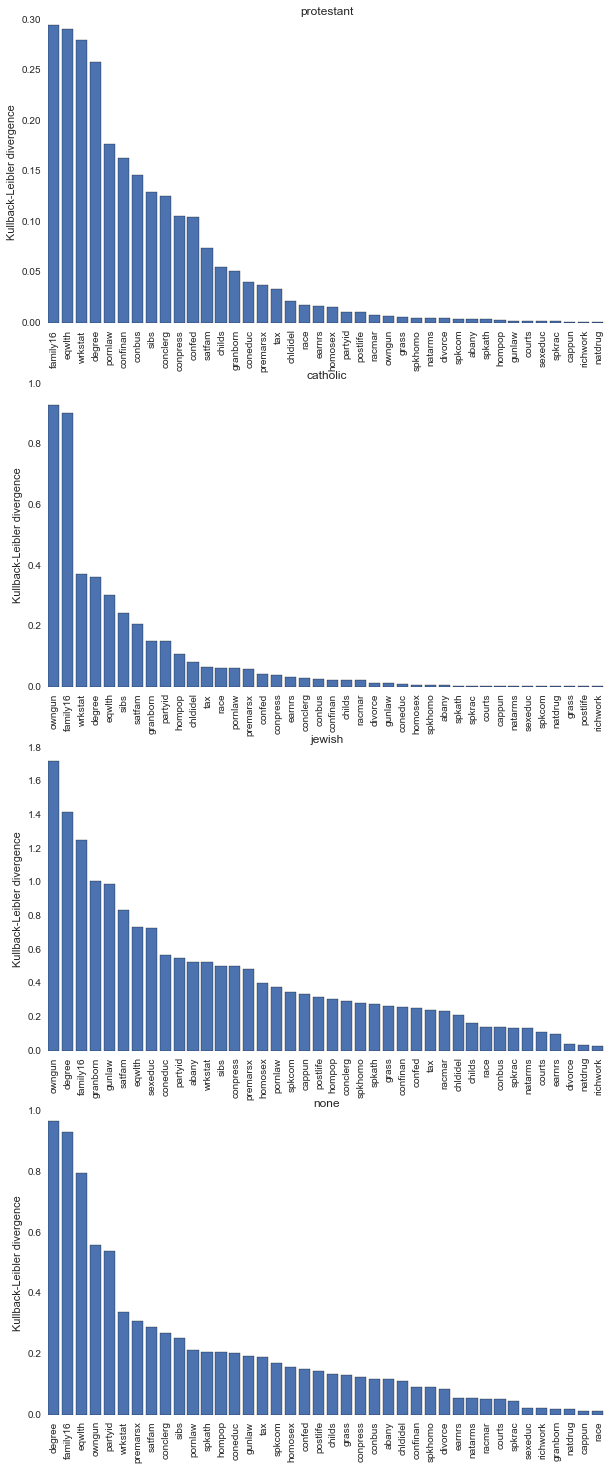

In [54]:
# plot the Kullback-Leibler divergence for a set of categories for the four largest religion groups
ListofCategories = ['wrkstat','divorce','sibs','childs','degree','hompop','partyid',
                    'natdrug','natarms','spkath','spkrac','spkcom','spkhomo','cappun','gunlaw','courts','grass',
                    'race','family16','granborn','earnrs','eqwlth','tax','postlife','racmar','satfam','confed',
                    'confinan','conclerg','conbus','coneduc','conpress','richwork','abany','chldidel','sexeduc',
                    'premarsx','homosex','pornlaw','owngun']
religions = ['protestant','catholic','jewish','none']
for i, religion in enumerate(religions):
    Divergencelist = ListofEntropies(ListofCategories, 'relig', religion)
    Divergences = []
    Categories = []
    numbers = np.arange(0, len(ListofCategories))
    for Divergence in Divergencelist:
        Divergences.append(Divergence[0])
        Categories.append(Divergence[1])
    plt.figure(1,(10,25))
    plt.subplot(len(religions), 1, i+1)
    plt.bar(numbers, Divergences)
    plt.xticks(np.arange(0.5, len(ListofCategories), 1), Categories, rotation = 90)
    plt.title(religion)
    plt.ylabel('Kullback-Leibler divergence')
    plt.tight_layout()
    

The bar graphs above show the divergence of 40 different questions for each of the four religions protestant, catholic, none, and other. It is striking that the highes Kullback-Leibler divergence of the protestant population is only 0.3. This is probably because the protestant population is a very large share of the total population, such that the answers between the two age groups do not differ very much.
The divergences for the jewish population is on average much higher. The jewish partial population is only a small share from the total population and apparently very much different as well.
The categories 'degree', 'family16', and 'owngun' seem most affected by the different religions. Also, notice the relatively high divergence of 'eqwlth' in the none-religion group.
In the next section I will plot the distribution of a particular answer for these three categories for both the total population and the partial population over time. I will also include a plot of the proportion of the particular religion over time such that it may give some insight in the other plots.

- The category degree asks for the highest obtained degree of the participant.
- Family16 asks about the living situation of the participant when he/she was sixteen.
- Owngun asks whether the partcipant owns a gun.


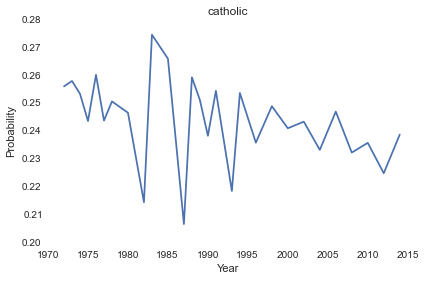

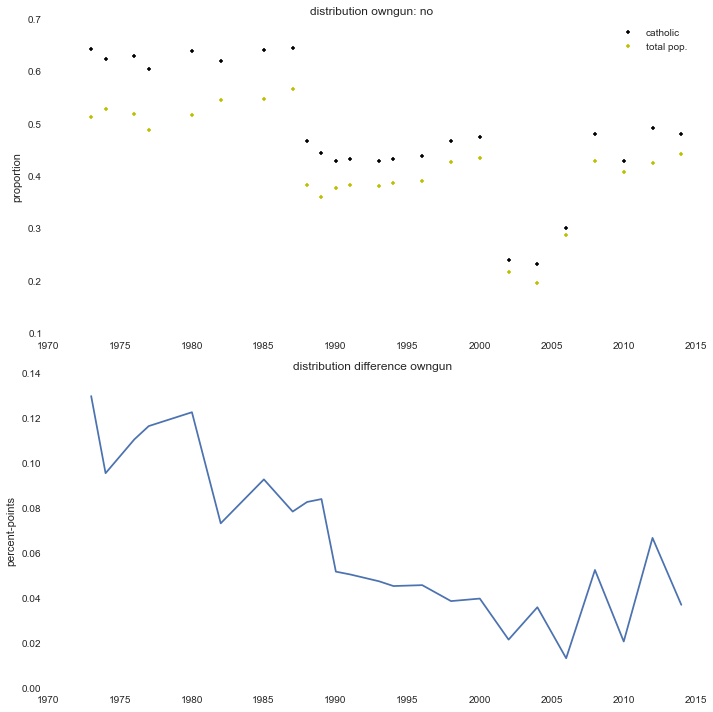

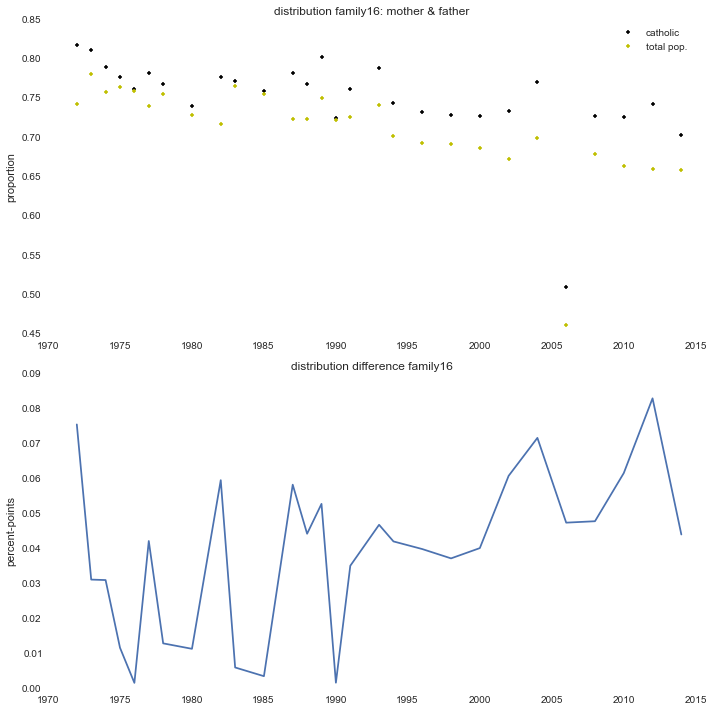

In [8]:
## First, I want to look at the catholic group in comparison with the total population. Here I plot the time development
## of the proportion of catholics in the total population, not owing a gun and of living with his/her mother & father 
## at the age of 16.
categories = ['owngun','family16']
answers = ['no', 'mother & father']
plt.figure(1)
Religionplots(total_data, ['catholic'], [])
for i in range(2):
    plt.figure(i+2, (10,10))
    plt.subplot(2,1,1)
    plt.plot(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'catholic')[1], distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'catholic')[0],'k.', label = 'catholic')
    plt.plot(distributiontotalpop(total_data, categories[i], answers[i])[1], distributiontotalpop(total_data, categories[i], answers[i])[0], 'y.', label = 'total pop.')
    plt.ylabel('proportion')
    plt.title('distribution ' + categories[i] + ': ' + answers[i])
    plt.legend(loc = 'best')
    plt.subplot(2,1,2)
    plt.plot(distributiontotalpop(total_data,categories[i], answers[i])[1], (np.asarray(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'catholic')[0]) - np.asarray(distributiontotalpop(total_data, categories[i], answers[i])[0])))
    plt.title('distribution difference ' + categories[i])
    plt.ylabel('percent-points')
    plt.tight_layout()


From the first plot, you can see that the share of catholic over time has been steadily around 24% of the total population. Only a very small negative slope can be seen, but it is too small to care about.
The catholic group, in blue, has proportionally a larger share of non-gun owners than in the total population. However, as can be seen in the second plot, the difference between the catholic population and the total population shrinks over time to below 5 percent points. The proportion of people living with both their mom and dad at an age of 16 has been consistently higher in the catholic group as compared to the total population with a difference of around 5 percent points, while no particular trend in the percent point difference can be seen.
Finally, we must note that it is striking that in both graphs, there is a negative peak around 2005. These may be an outlier or even, perhaps, a mistake in the preprocessing.

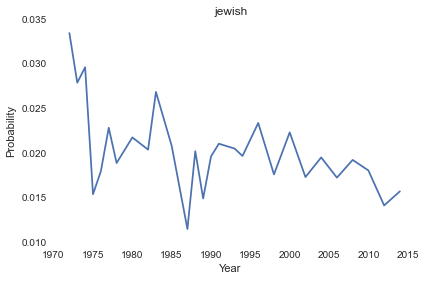

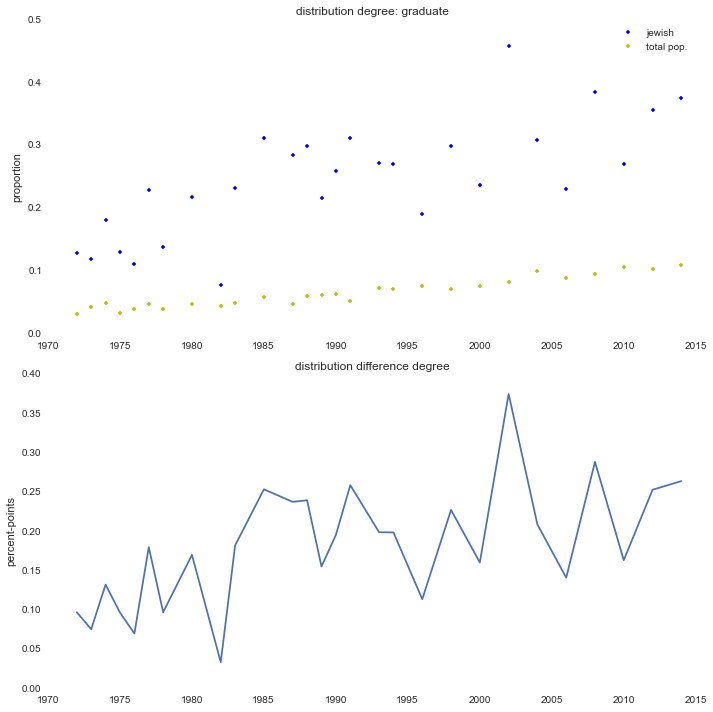

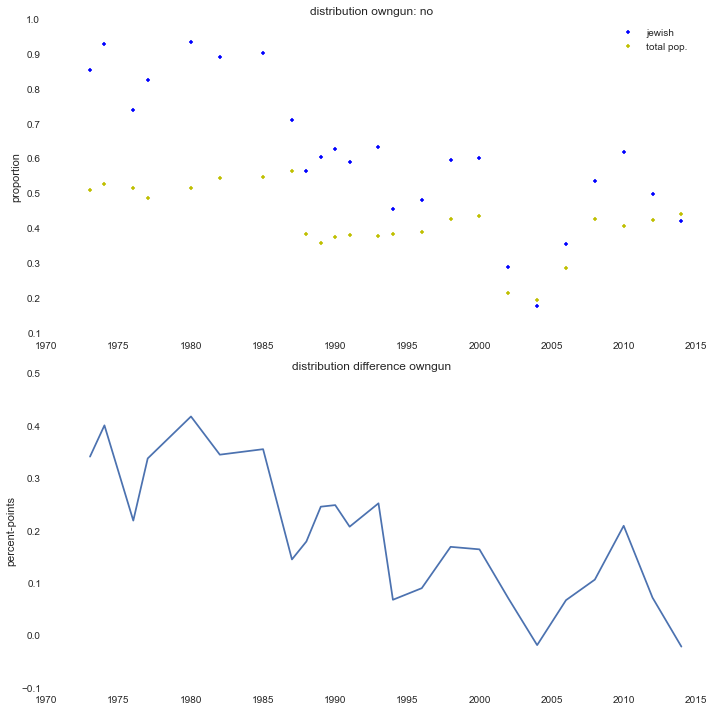

In [9]:
## For the jewish partial population the categories 'degree' and 'owngun' have turned out to be most influenced by 
## the religion here I will plot the proportion of the jewish population, the proportion of graduates and 
## the proportion of non-gun owners for the jewish population, total population and its difference in percent-points.
categories = ['degree','owngun']
answers = ['graduate', 'no']
plt.figure(1)
Religionplots(total_data, ['jewish'], [])
for i in range(2):
    plt.figure(i+2, (10,10))
    plt.subplot(2,1,1)
    plt.plot(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'jewish')[1], distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'jewish')[0], 'b.', label = 'jewish')
    plt.plot(distributiontotalpop(total_data, categories[i], answers[i])[1], distributiontotalpop(total_data, categories[i], answers[i])[0], 'y.', label = 'total pop.')
    plt.ylabel('proportion')
    plt.title('distribution ' + categories[i] + ': ' + answers[i])
    plt.legend(loc = 'best')
    plt.subplot(2,1,2)
    plt.plot(distributiontotalpop(total_data,categories[i], answers[i])[1], (np.asarray(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'jewish')[0]) - np.asarray(distributiontotalpop(total_data, categories[i], answers[i])[0])))
    plt.title('distribution difference ' + categories[i])
    plt.ylabel('percent-points')
    plt.tight_layout()

The share of the Jewish population with respect to the total population is only small, around 2% and even decreasing over time. The difference with the total population, in both the degree and the owngun categories is quite big: The proportion of people having a graduate degree is around 25 percent points higher than in the total population. Also, this proportion is increasing in both groups, but it must be noted that the increases faster in the Jewish group. From the second set of graphs, you can see that a smaller share in the Jewish group owns a gun than in the total population. But the difference is decreasing since, apparently, more and more people in the Jewish groups have answered 'yes' to the question whether they owned a gun. In the total population this increase of gun owners is not as distinct.

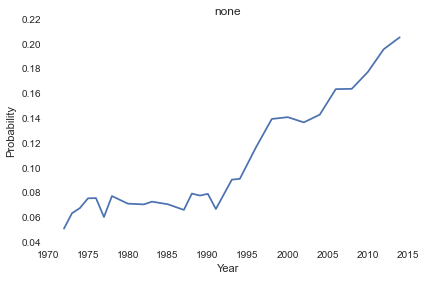

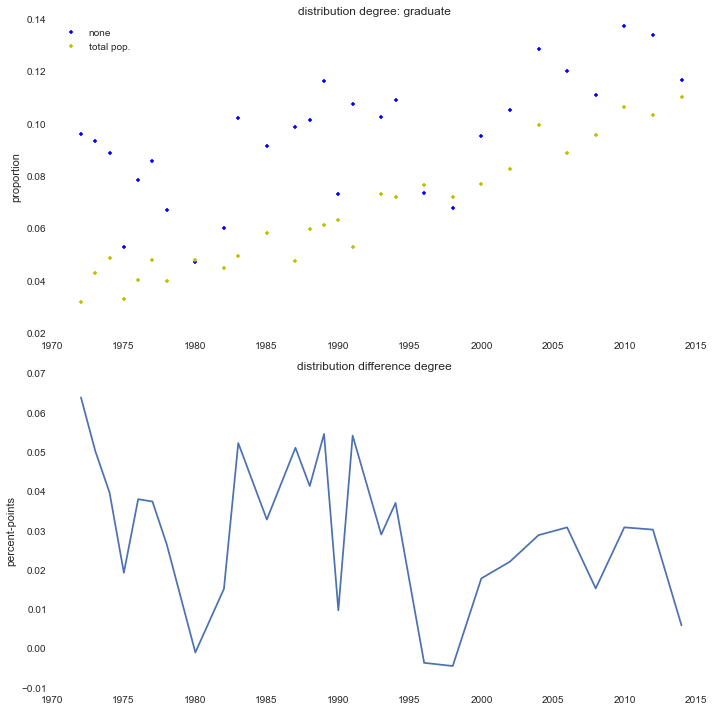

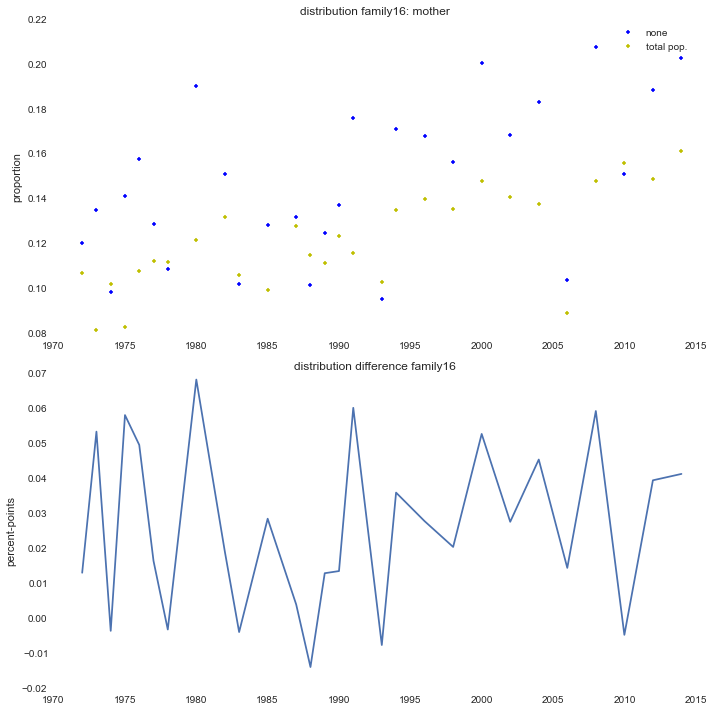

In [10]:
## finally, we look at the none religion category. Here, 'family16' and degree turned out to be influenced the most by 
## the partial population. We plot the answers 'raised only by mother' and 'graduate degree' over time for the partial
## population and the total population. We also plot the difference in percent-points.
categories = ['degree','family16']
answers = ['graduate', 'mother']
plt.figure(1)
Religionplots(total_data, ['none'], [])
for i in range(2):
    plt.figure(i+2, (10,10))
    plt.subplot(2,1,1)
    plt.plot(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'none')[1], distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'none')[0], 'b.', label = 'none')
    plt.plot(distributiontotalpop(total_data, categories[i], answers[i])[1], distributiontotalpop(total_data, categories[i], answers[i])[0], 'y.', label = 'total pop.')
    plt.ylabel('proportion')
    plt.title('distribution ' + categories[i] + ': ' + answers[i])
    plt.legend(loc = 'best')
    plt.subplot(2,1,2)
    plt.plot(distributiontotalpop(total_data,categories[i], answers[i])[1], (np.asarray(distributionpartialpop(total_data, categories[i],answers[i], 'relig', 'none')[0]) - np.asarray(distributiontotalpop(total_data, categories[i], answers[i])[0])))
    plt.title('distribution difference ' + categories[i])
    plt.ylabel('percent-points')
    plt.tight_layout()

The group of people belonging to no religion, clearly increases over time, from only a small group in the 1970s (~5%) to approximately a fifth of the population in the present. In the degree category, it can be seen that certainly early on, in the no-religion group more people had a graduate degree. But the share of the total population having a graduate degree has been rising with a higher slope than in the no-religion group such that the difference in percent-points is decreasing over time, although the share of graduate-holding respondents in the no-religion is group is still higher than in the total population. 
The share of people living with their mom at the age of 16 is slightly larger in the no-religion group than in the total population group. Looking at the scatter plot, it could be said the slope of the curve for the no-religion is a bit higher than in the total population group, but that is not certain at all.

## Degree 

Because I found the difference of the distribution of people holding a graduate degree of the total population and the jewish population or the non-religion population very interesting, I plot below the time evolution of the different answers in the degree-category for the total population, the jewish population, and the non-degree population.

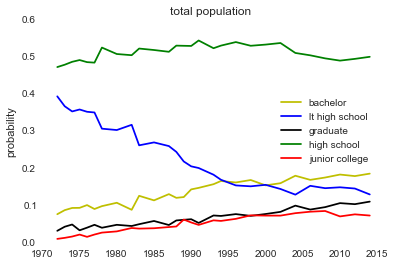

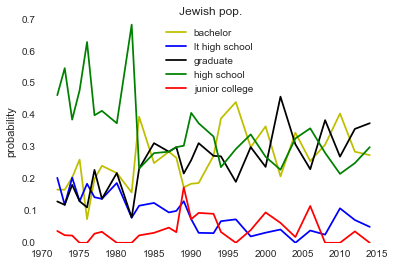

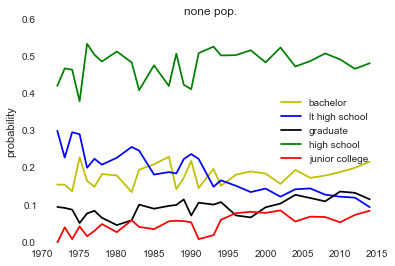

In [11]:
plt.figure(1)
plt.plot(distributiontotalpop(total_data, 'degree', 'bachelor')[1], distributiontotalpop(total_data, 'degree', 'bachelor')[0], color='y', label = 'bachelor')
plt.plot(distributiontotalpop(total_data, 'degree', 'lt high school')[1], distributiontotalpop(total_data, 'degree', 'lt high school')[0], color='b', label = 'lt high school')
plt.plot(distributiontotalpop(total_data, 'degree', 'graduate')[1], distributiontotalpop(total_data, 'degree', 'graduate')[0], color='k', label = 'graduate')
plt.plot(distributiontotalpop(total_data, 'degree', 'high school')[1], distributiontotalpop(total_data, 'degree', 'high school')[0], color='g', label = 'high school')
plt.plot(distributiontotalpop(total_data, 'degree', 'junior college')[1], distributiontotalpop(total_data, 'degree', 'junior college')[0], color='r', label = 'junior college')
plt.legend(loc = 'best')
plt.title('total population')
plt.ylabel('probability')
plt.figure(2)
plt.plot(distributionpartialpop(total_data, 'degree', 'bachelor','relig','jewish')[1], distributionpartialpop(total_data, 'degree', 'bachelor','relig','jewish')[0], color='y', label = 'bachelor')
plt.plot(distributionpartialpop(total_data, 'degree', 'lt high school','relig','jewish')[1], distributionpartialpop(total_data, 'degree', 'lt high school','relig','jewish')[0], color='b', label = 'lt high school')
plt.plot(distributionpartialpop(total_data, 'degree', 'graduate','relig','jewish')[1], distributionpartialpop(total_data, 'degree', 'graduate','relig','jewish')[0], color='k', label = 'graduate')
plt.plot(distributionpartialpop(total_data, 'degree', 'high school','relig','jewish')[1], distributionpartialpop(total_data, 'degree', 'high school','relig','jewish')[0], color='g', label = 'high school')
plt.plot(distributionpartialpop(total_data, 'degree', 'junior college','relig','jewish')[1], distributionpartialpop(total_data, 'degree', 'junior college','relig','jewish')[0], color='r', label = 'junior college')
plt.legend(loc= 'best')
plt.title('Jewish pop.')
plt.ylabel('probability')
plt.figure(3)
plt.plot(distributionpartialpop(total_data, 'degree', 'bachelor','relig','none')[1], distributionpartialpop(total_data, 'degree', 'bachelor','relig','none')[0], color='y', label = 'bachelor')
plt.plot(distributionpartialpop(total_data, 'degree', 'lt high school','relig','none')[1], distributionpartialpop(total_data, 'degree', 'lt high school','relig','none')[0], color='b', label = 'lt high school')
plt.plot(distributionpartialpop(total_data, 'degree', 'graduate','relig','none')[1], distributionpartialpop(total_data, 'degree', 'graduate','relig','none')[0], color='k', label = 'graduate')
plt.plot(distributionpartialpop(total_data, 'degree', 'high school','relig','none')[1], distributionpartialpop(total_data, 'degree', 'high school','relig','none')[0], color='g', label = 'high school')
plt.plot(distributionpartialpop(total_data, 'degree', 'junior college','relig','none')[1], distributionpartialpop(total_data, 'degree', 'junior college','relig','none')[0], color='r', label = 'junior college')
plt.legend(loc= 'best')
plt.title('none pop.')
plt.ylabel('probability')

In the total population, the distributions of all the different degrees have clear trends. It looks like that the largest share of the people have done high school as their highest education, steadily around 50%. The lt high school category is also interesting, having a large share in the beginning but sharply decreasing over time. It seems that this is an old-fashioned degree that is being replaced by other types of degrees. 

The difference between the total population and the none-religion population is not very big. Maybe the none-beleivers are very nicely evenly spread over the total population. The difference with the jewish population is striking though: The Jewish population is about evenly divided into three groups: high school, bachelor, and graduate (while also in the early years, the lt high school played a role).

An interesting feature to look at would be this highest obtained degree. We could look at the different categories and build a model based on the answers to all these questions to predict what the highest obtained degree is.
We can look at the Kullback-Leibler divergence between the total population and a partial population (answering a particular answer to a particular question) to look at the influence of different categories on the degree category. And use this to deduce what questions should be put in the model. In the next block we do this for a set of partial 
populations.

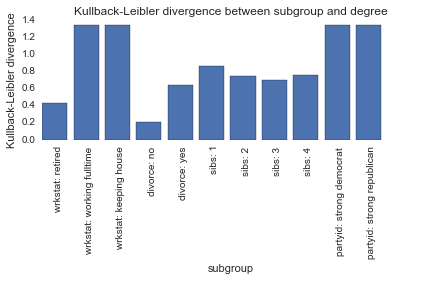

In [33]:
ListofCategories = ['wrkstat','wrkstat','wrkstat','divorce','divorce','sibs','sibs','sibs','sibs','partyid',
                    'partyid']
listofanswers = ['retired', 'working fulltime', 'keeping house', 'no', 'yes',1,2,3,4,'strong democrat','strong republican']
## we modify our entropy function to return a list of tuples of divergences between the total population and a
## subcategory of listofcategories:
divergences = []
for i, category in enumerate(ListofCategories):
    cdivergences = []
    for year in total_data.keys():
        if 'degree' in total_data[year] and category in total_data[year]:
            cdivergences.append(Entropy(year, 'degree', category, listofanswers[i]))
    divergences.append(np.mean(cdivergences))
namelist = []
for i in range(len(ListofCategories)):
    name = ListofCategories[i] + ': ' + str(listofanswers[i])
    namelist.append(name)
numbers = np.arange(0, len(ListofCategories))                 
plt.bar(numbers, divergences)
plt.xticks(np.arange(0.5,len(ListofCategories), 1), namelist, rotation = 90) 
plt.ylabel('Kullback-Leibler divergence')
plt.title('Kullback-Leibler divergence between subgroup and degree')
plt.xlabel('subgroup')
plt.tight_layout()

# Model of Logistic Regression to predict atheists


In [ ]:
# Returns the Kullback-Leibler divergence between the answers to category1 of the total population and 
# subcategory of category 2
def NonRelEntropy(year, category1, category2, subcategory):
    dist1 = CrossProportions(year, category1, category2, subcategory)
    print dist1
    if type(dist1) == str:
        return dist1
    dist2 = Proportions(year, category1)
    print dist2
    if len(dist1) != len(dist2):
        params = [dist1, dist2]
        lengths = [len(dist1), len(dist2)]
        maxlength = max(lengths)    
        for param in params:
            if len(param) < maxlength:
                for i in range(maxlength - len(param)):
                    param.append(1e-16)
    entropy = sp.stats.entropy(dist1, dist2)
    return entropy

In [109]:
ListofCategories = ['wrkstat','divorce','sibs','childs','degree','hompop','partyid',
                    'natdrug','natarms','spkath','spkrac','spkcom','spkhomo','cappun','gunlaw','courts','grass',
                    'race','family16','granborn','earnrs','eqwlth','tax','postlife','racmar','confed',
                    'confinan','conclerg','conbus','coneduc','conpress','richwork','abany','chldidel','sexeduc',
                    'premarsx','homosex','pornlaw','owngun']

def QuestionSelect(year, category, subcategory):        
    # outputs an array with a question, the possible answers, and the proportion of the people who gave a certain answer and are non-religious
    data = total_data[year]
    all_props = []
    cat_answers_props = []   # This array will contain the category as an item, and an array of answers + proportions

    # total proportion non-relig
    counted = Count(year, category)
    totalcount = np.sum(counted.values())
    nonecount = counted[subcategory]
    totalprop = float(nonecount) / float(totalcount)
    selected_questions = []
    todo = 1111
    # The block below filters the categories, removing those with many possible answers and inconsistent answer types
    for cat in data.keys():
        todo -= 1 
        print todo
        answers = np.unique(data[cat])
        for answer in answers:
            if (data[cat] == answer).sum() > 500:

        # Als een van de antwoorden in een categorie niet goed is, gooi je meteen de hele categorie weg. Beter om dit 
        # op het niveau van antwoorden te doen, zodat we geen informatie weggooien.
#                 cat_answers_props = []
#                 cat_answers_props.append(cat)


                subcatanswered = np.sum(data[data[cat] == answer][category] == subcategory)
                totalanswered = len(data[data[cat] == answer])

                if subcatanswered == 0: # Volgens mij gaat hier nog iets mis: ik denk dat als subcatanswered==0, we 
                                        #hem sowieso niet willen hebben.
                    pass
                else:
                    answerprop = float(subcatanswered) / float(totalanswered)
                    diff = float(answerprop) - float(totalprop)
                    selected = [cat, answer, diff]
                    if diff > 0.016:
                        if selected not in selected_questions:
                            selected_questions.append(selected)

                    if diff < -0.016:
                        if selected not in selected_questions:
                            selected_questions.append(selected)

                    # see also comment at the end. Comparison with totalprop should be done here. Then decide whether to 
                    # include the category + answer

#                 all_props.append(cat_answers_props)


    
    return selected_questions
            

#Or, actually, maybe move the comparison with totalprop also into the preprocessing. This way we have only one loop,
#which makes it more efficient.
        


print 'None', QuestionSelect('2000', 'relig', 'none')


None 1110
1109
1108
1107
1106
1105
1104
1103
1102
1101
1100
1099
1098
1097
1096
1095
1094
1093
1092
1091
1090
1089
1088
1087
1086
1085
1084
1083
1082
1081
1080
1079
1078
1077
1076
1075
1074
1073
1072
1071
1070
1069
1068
1067
1066
1065
1064
1063
1062
1061
1060
1059
1058
1057
1056
1055
1054
1053
1052
1051
1050
1049
1048
1047
1046
1045
1044
1043
1042
1041
1040
1039
1038
1037
1036
1035
1034
1033
1032
1031
1030
1029
1028
1027
1026
1025
1024
1023
1022
1021
1020
1019
1018
1017
1016
1015
1014
1013
1012
1011
1010
1009
1008
1007
1006
1005
1004
1003
1002
1001
1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890


In [ ]:
ListofCategories = ['wrkstat','wrkstat','wrkstat','divorce','divorce','sibs','sibs','sibs','sibs','partyid',
                    'partyid','relig']
listofanswers = ['retired', 'working fulltime', 'keeping house', 'no', 'yes',1,2,3,4,'strong democrat',
                 'strong republican','none']
BooleanMatrix = []
index = []
for i in range(len(listofanswers)):
    a = total_data['2000'][ListofCategories[i]] == listofanswers[i]
    booleans = []
    for answer in a:
        if answer == False:
            booleans.append(0)
        else:
            booleans.append(1)
    booleans = np.array(booleans)        
    BooleanMatrix.append(booleans)
    index.append(ListofCategories[i] + ': ' + str(listofanswers[i]))
    
DataFrame = pd.DataFrame(BooleanMatrix, index = index )
DataFrame = DataFrame.T

Ydata = DataFrame2010['relig: none']
DataFrame.drop('relig: none', axis =1)



In [ ]:
# First we need to divide the sample into a training part and a testing part:
labelAccuracy = []
coef = []
sss = scv.StratifiedShuffleSplit(Ydata, test_size=0.3)
for train_index, test_index in sss:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = DataFrame.T[train_index], DataFrame.T[test_index]
    y_train, y_test = Ydata[train_index], Ydata[test_index]
    m = slm.LogisticRegression(C=10, dual=True) 
    m.fit(X_train.T, y_train)
    labelAccuracy.append(m.score(X_test.T, y_test))
    coef.append(m.coef_.squeeze())  

labelAccuracy = np.array(labelAccuracy)
print np.array(labelAccuracy).mean()
print labelAccuracy
m.score(DataFrame2010, DataFrame2010['relig: none'])

In [99]:
data = total_data['2000'];
for cat in data:
    print data.

np.sum(data[data['owngun'] == 'yes']['relig'] == 'none')

TypeError: 'Int64Index' object is not callable

In [78]:
a = [[1,2,3,1,4,2], [1,2,6,1,4,2], [1,2,2,1,4,2], [1,2,3,1,4,2]]
if [3,1,4,2] not in a:
    print 'not in a'
else:
    print 'in a'

not in a


In [101]:
output1 = [['attend', 'never', 0.2806703480644044], ['fund16', 'liberal', 0.12235130861328941], ['fund', 'liberal', 0.3470298281257573], ['fund', 'moderate', -0.14030177085394932]]
print output1
answer =0 
for i in range(10):
    answer += 1
    print answer

[['attend', 'never', 0.2806703480644044], ['fund16', 'liberal', 0.12235130861328941], ['fund', 'liberal', 0.3470298281257573], ['fund', 'moderate', -0.14030177085394932]]
1
2
3
4
5
6
7
8
9
10
